# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import types
import pyspark.sql
import pyspark.sql.functions

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation


### Background 

The following analysis is based on a Kaggle dataset from Criteo, an internet advertising company focused on retargeting. Criteo's goal is to increase online clickthrough rates among consumers who have previously visited an advertiser's website. This information will be used by Criteo to more efficiently provide the right ads to the right people. Optimizing the retargeting process not only helps advertisers become more efficient in terms of how they spend their dollars, but also it reduces clutter for consumers who do not want to be "followed" by ads for irrelevant products (or ones they may have already purchased!).

There are 13 numerical features and 26 categorical features in this dataset. Our goal is to create a model that will most accurately predict clickthroughs (label = 1). It is likely that these features represent characterstics about consumer behavior (history of clickthroughs, site visitiation, etc.), the ads themselves (product, creative approach, placement, etc.) and general metrics such as the date the ad was published. Since there is no visibility into what each feature represents, however, our challenge is to make our predictions based on the data alone. With over 6 million records, this will require a scalable approach.

### Key Questions

* Which machine learning approach not only provides the highest accuracy in predicting clickthroughs, but is also scalable enough to be useful in a production environment? As internet patterns and product choices change rapidly, the ideal model should be updated daily to update the following day's retargeting model.  - Note: not sure I fully answered this piece:  *** Preview what level of performanceyour model would need to achieve to be practically useful ***

* Which features are most important in predicting clickthroughs? Having this information can help Criteo focus on the metrics that are most critical to their product.

* With 39 features, there is a high risk of overfitting. We should identify a model that provides an optimal tradeoff between bias and variance.

### Dataset Introduction 

The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates) in order to reduce the dataset size.

There are 13 features taking integer values (mostly count features) and 26 categorical features. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed. Some features may have missing values.

The rows are chronologically ordered. The test set is computed in the same way as the training set but it 
corresponds to events on the day following the training period and does not have the label column.

#### Train File:

* Number of rows: 45840617 (~ 45 million)
2. Number of columns: 40 Columns
    -  13 Numerical Features I1-I13
    -  26 Categorical Features C1-C26
    -  1 Label Column - 0 or 1  
3. **Numerical Columns Analysis**:
4. **Categorical Columns Analysis**:
5. **Output Column Analysis**:
    -  Binary variable with values as 0 or 1 
    -  0 - user clicked on the ad, 1 - user did not click on the ad

#### Test File:

1. Number of rows: 6042135 (~ 6 million)
2. Number of columns: 
3. Numerical Columns Analysis:
4. Categorical Columns Analysis:
5. Output Column Analysis:




## 2. EDA & Discussion of Challenges

In this section, we will perform an EDA and data transformations using Spark RDDs on a toy dataset randomly sampled from the full Criteo train data. Our analysis includes data exploration and visualizations that help inform our data transformation decisions. 

**NOTE:** In section 4, we perform the same data transformations/EDA on the entire dataset using Spark Dataframes. 

### 2.1 Data Loading

In [4]:
# take a look at the data
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# load the data
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [7]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


### 2.2 Creating Train and Test Split

In [6]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


### 2.3 Creating a toy RDD

A toy data set was created by randomly sampling 1000 records from the dataset: 

`!gshuf -n 1000 data/train.txt >> data/toy1000.txt`

In [203]:
toyRDD = sc.textFile('data/toy1000.txt')
print(f"Number of records in toy data: {toyRDD.count()} ...")

Number of records in toy data: 1000 ...


In [205]:
print(toyRDD.take(1))

['1\t0\t478\t13\t\t3396\t194\t11\t13\t312\t0\t7\t\t\t05db9164\t207b2d81\t1757640a\t06148e59\t25c83c98\tfbad5c96\tf36791d8\t0b153874\ta73ee510\tc7009b63\t2714650d\t1a69f1c0\t9a88e2e2\t07d13a8f\t0c67c4ca\t8075af0c\te5ba7672\t395856b0\t21ddcdc9\tb1252a9d\t8e4884c0\t\t423fab69\tb936bfbe\t001f3601\tf2fc1d6e']


### 2.4 Pre-Processing

In [206]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append('null')
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [207]:
# Parsing, making '' as np.nan and converting numerical features and output label to int
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()
toyRDDCached = toyRDD.map(parse).map(edit_data_types).cache()

In [209]:
print(toyRDDCached.take(1))

[([0.0, 478.0, 13.0, 'null', 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 'null', 'null', '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### 2.4.1 Some extra pre-processing for a pandas DataFrame for EDA use

In [228]:
# helper function 'null' to np.nan for pandas df 
def null_to_nan(line):
    """
    converts "null" to np.nan in RDD
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == 'null':
            formated_features.append(np.nan)
        else:
            formated_features.append(value)
    return (formated_features, label)

# put the toy RDD into a pandas dataframe for EDA charting
toyRDDtoPandas = toyRDDCached.map(null_to_nan) \
                                .map(lambda x: np.append(x[0], [x[1]])) \
                                .collect()

toy_df = pd.DataFrame(toyRDDtoPandas, columns=FIELDS)

In [229]:
toy_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.0,478.0,13.0,nan,3396.0,194.0,11.0,13.0,312.0,0.0,...,395856b0,21ddcdc9,b1252a9d,8e4884c0,nan,423fab69,b936bfbe,001f3601,f2fc1d6e,1
1,2.0,0.0,nan,nan,1209.0,0.0,2.0,1.0,0.0,1.0,...,526e8765,nan,nan,8b7fb864,nan,32c7478e,45b2acf4,nan,nan,0
2,nan,1.0,1.0,8.0,489.0,66.0,0.0,11.0,8.0,nan,...,8f9b4e88,nan,nan,050a23dc,nan,32c7478e,8a3cfad4,nan,nan,0
3,0.0,179.0,7.0,8.0,996.0,67.0,6.0,44.0,344.0,0.0,...,2804effd,nan,nan,723b4dfd,nan,32c7478e,b34f3128,nan,nan,0
4,2.0,2.0,10.0,27.0,1101.0,29.0,11.0,42.0,241.0,1.0,...,e88ffc9d,21ddcdc9,b1252a9d,dca9a28d,ad3062eb,bcdee96c,3fdb382b,cb079c2d,1c2df582,1


### 2.5 Labels

First we take a look at the percentage of records that belong to each label for our classification problem in order to determine whether our classes are balanced. 

In [12]:
# TOY DATA
# counting records for each class 
count_label_0 = toyRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = toyRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

72.3 % of the records have label=0 and 27.7 % have label=1...


In [13]:
# FULL DATA
# counting records for each class 
count_label_0 = trainRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = trainRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

74.38 % of the records have label=0 and 25.62 % have label=1...


The result above show that the **labels are imbalanced**, with 75% of records having label=0 (i.e. unclicked ads). However, we will not attempt to balance the labels at this stage. Being aware of this imbalance, we will carefully examine the prediction results to detect any model bias (i.e. predicting always label=0)

### 2.6 Counting nulls in each column

Then, we take a look at the percentage of null values for all columns in our dataset. 

In [219]:
def get_pct_nulls_in_column(dataRDD, var_position):
    """
    Counts the % nulls in a column 
    """

    null_count = dataRDD.map(lambda x: x[0][var_position]) \
                             .filter(lambda x: x == 'null').count()
    total_count = dataRDD.map(lambda x: x[0][var_position]).count()

    return null_count/total_count*100

In [220]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position < 39:
        null_pct = get_pct_nulls_in_column(toyRDDCached, var_position)
        print("FEATURE {}: {}% is null".format(var, np.round(null_pct,2)))

FEATURE I1: 43.2% is null
FEATURE I2: 0.0% is null
FEATURE I3: 21.3% is null
FEATURE I4: 22.1% is null
FEATURE I5: 2.4% is null
FEATURE I6: 23.0% is null
FEATURE I7: 3.7% is null
FEATURE I8: 0.0% is null
FEATURE I9: 3.7% is null
FEATURE I10: 43.2% is null
FEATURE I11: 3.7% is null
FEATURE I12: 77.4% is null
FEATURE I13: 22.1% is null
FEATURE C1: 0.0% is null
FEATURE C2: 0.0% is null
FEATURE C3: 3.4% is null
FEATURE C4: 3.4% is null
FEATURE C5: 0.0% is null
FEATURE C6: 13.4% is null
FEATURE C7: 0.0% is null
FEATURE C8: 0.0% is null
FEATURE C9: 0.0% is null
FEATURE C10: 0.0% is null
FEATURE C11: 0.0% is null
FEATURE C12: 3.4% is null
FEATURE C13: 0.0% is null
FEATURE C14: 0.0% is null
FEATURE C15: 0.0% is null
FEATURE C16: 3.4% is null
FEATURE C17: 0.0% is null
FEATURE C18: 0.0% is null
FEATURE C19: 42.2% is null
FEATURE C20: 42.2% is null
FEATURE C21: 3.4% is null
FEATURE C22: 74.5% is null
FEATURE C23: 0.0% is null
FEATURE C24: 3.4% is null
FEATURE C25: 42.2% is null
FEATURE C26: 42.2%

We notice that some columns have a high % of null values. We could exclude columns that have more than 50% nulls because those columns will likely not contribute a lot to the prediction results. However, since those variables with more than 50% missing values are categorical variables, the one-hot encoding approach that we will take later on will take care of this issue.

### 2.7 Numeric Features

#### 2.7.1 Get Summary Statistics and Distributions

Next, we take a look at the summary statistics for our numerical features in order to determine their distributions and detect outliers. 

In [244]:
# RDD version 
def get_stats(dataRDD, var_position):
    """
    Get statistics for numeric variables 
    stats: mean, median, variance, min, max 
    """

    mean = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').mean() 
    variance = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').variance() 
    minimum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').min() 
    maximum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').max() 

    return mean, variance, minimum, maximum

In [245]:
# save the means in a dictionary
mean_dict_toy = {}
st_dev_dict_toy = {}

# get summary stats with RDDs
for var_position, var in enumerate(FIELDS):
    if var_position < 13:
        mean, variance, minimum, maximum = get_stats(toyRDDCached, var_position)
        print("FEATURE {}: \t mean={}, \t variance={}, \t min={}, \t max={}".format(var, np.round(mean, 2), np.round(variance, 2), minimum, maximum))
        mean_dict_toy[var_position] = mean
        st_dev_dict_toy[var_position] = np.sqrt(variance)

FEATURE I1: 	 mean=3.17, 	 variance=33.98, 	 min=0.0, 	 max=55.0
FEATURE I2: 	 mean=114.72, 	 variance=179230.84, 	 min=-2.0, 	 max=5123.0
FEATURE I3: 	 mean=18.78, 	 variance=2026.69, 	 min=0.0, 	 max=648.0
FEATURE I4: 	 mean=7.43, 	 variance=86.02, 	 min=0.0, 	 max=77.0
FEATURE I5: 	 mean=18392.77, 	 variance=4908735552.87, 	 min=0.0, 	 max=1002457.0
FEATURE I6: 	 mean=95.23, 	 variance=65007.31, 	 min=0.0, 	 max=4304.0
FEATURE I7: 	 mean=17.94, 	 variance=8794.35, 	 min=0.0, 	 max=2614.0
FEATURE I8: 	 mean=12.96, 	 variance=183.6, 	 min=0.0, 	 max=49.0
FEATURE I9: 	 mean=102.42, 	 variance=38152.34, 	 min=0.0, 	 max=2711.0
FEATURE I10: 	 mean=0.64, 	 variance=0.5, 	 min=0.0, 	 max=4.0
FEATURE I11: 	 mean=2.78, 	 variance=23.83, 	 min=0.0, 	 max=60.0
FEATURE I12: 	 mean=1.19, 	 variance=40.19, 	 min=0.0, 	 max=84.0
FEATURE I13: 	 mean=7.99, 	 variance=116.35, 	 min=0.0, 	 max=97.0


In [246]:
# Pandas version 
num_columns = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']
toy_df_num = toy_df[num_columns].astype(np.float)
toy_df_num.describe()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,568.000000,1000.000000,787.000000,779.000000,9.760000e+02,770.000000,963.000000,1000.000000,963.000000,568.000000,963.000000,226.000000,779.000000
mean,3.167254,114.719000,18.780178,7.427471,1.839277e+04,95.231169,17.942887,12.961000,102.419522,0.642606,2.778816,1.194690,7.993582
std,5.834144,423.568469,45.047402,9.280591,7.009829e+04,255.131025,93.826907,13.556669,195.427732,0.705795,4.884305,6.353803,10.793634
min,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,3.032500e+02,6.000000,1.000000,2.000000,10.500000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,2.000000,6.000000,4.000000,2.696000e+03,28.000000,3.000000,8.000000,39.000000,1.000000,1.000000,0.000000,4.000000
75%,4.000000,32.000000,18.000000,10.000000,9.703500e+03,92.750000,12.000000,20.000000,101.000000,1.000000,3.000000,0.000000,10.000000
max,55.000000,5123.000000,648.000000,77.000000,1.002457e+06,4304.000000,2614.000000,49.000000,2711.000000,4.000000,60.000000,84.000000,97.000000


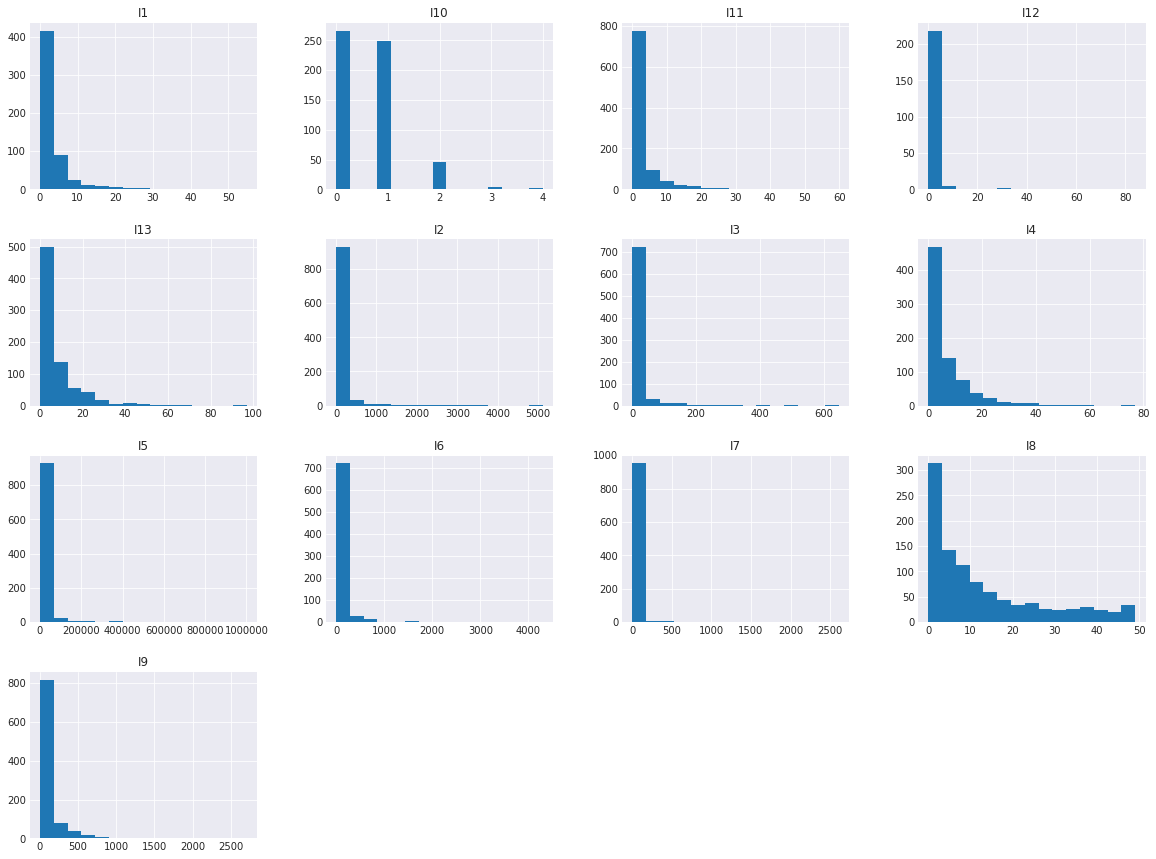

In [247]:
# Take a look at histograms for each numeric feature 
toy_df_num.hist(figsize=(20,15), bins=15)
plt.show()

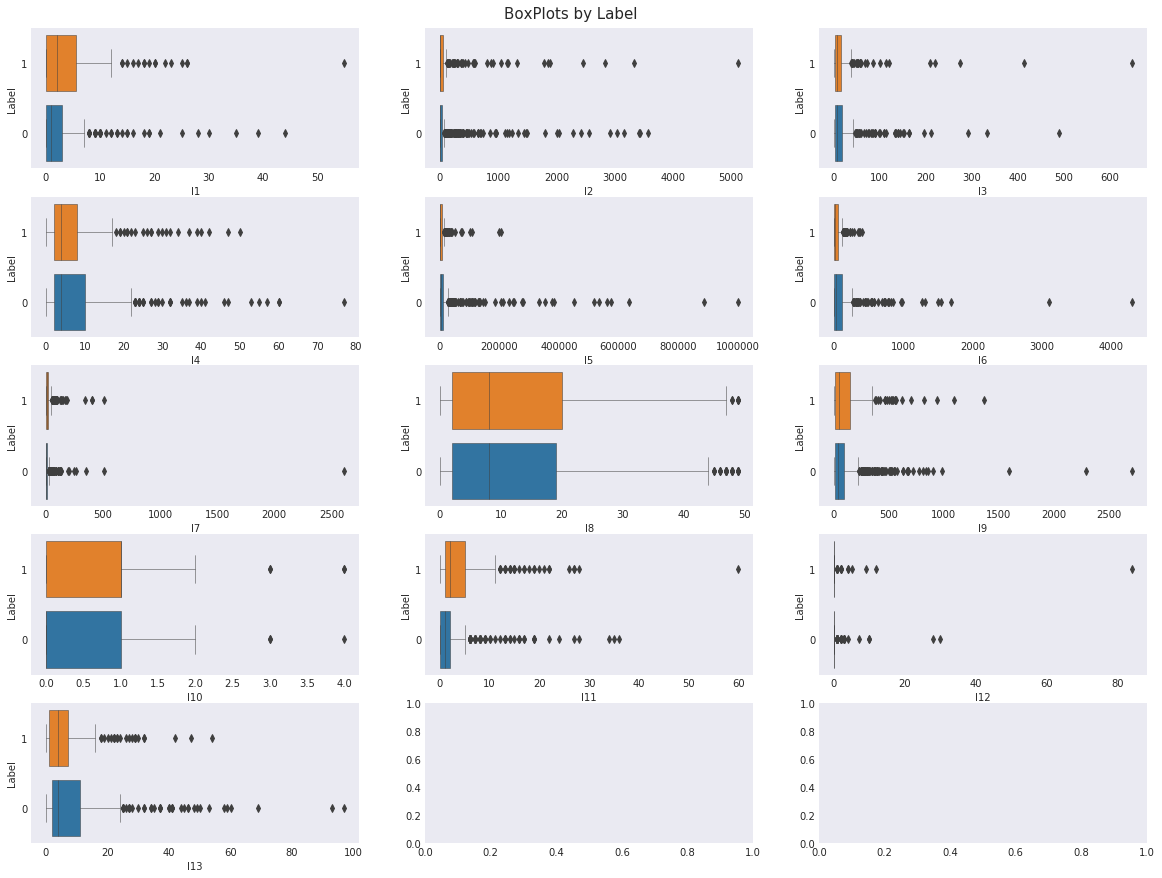

In [239]:
# plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(5, 3, figsize=(20,15))
y = toy_df['Label']
for idx, feature in enumerate(num_columns):
    x = toy_df_num[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

The above results show that most of the numeric features are heavily skewed with several outliers on the right end. We also notice that variable `I10` is a categorical variable and not numerical.

#### 2.7.2 Impute nulls with medians

Next, we decide to impute the missing values in the numeric features with the median value for each corresponding column. The choice of median instead of mean is made due to the multiple large outliers on the high end that would have caused our mean values to be larger. Note, that there is no need to impute the null values for the categorical features since one hot encoding will take care of the nulls later on. 

In [221]:
def impute_nulls(line, mean_or_median_dict):
    """
    Impute the null values of the numerical columns with the mean value of the column
    """
    features, label = line[0], line[1]
    imputed_features = []
    for i, value in enumerate(features):
        if i < 13: 
            if value == 'null':
                imputed_features.append(mean_or_median_dict[i])
            else:
                imputed_features.append(value)
        else: 
            imputed_features.append(value)
    return (imputed_features, int(label))

In [255]:
# getting the median with pandas because RDDs don't have a built-in function 
medians = toy_df_num.median().tolist()
median_dict_toy = dict(zip(mean_dict_toy.keys(), medians))

In [256]:
# imputing nulls with median 
imputedToyRDDCached = toyRDDCached.map(lambda x: impute_nulls(x, median_dict_toy)).cache()

In [258]:
print(imputedToyRDDCached.take(1))

[([0.0, 478.0, 13.0, 4.0, 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 0.0, 4.0, '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### 2.7.3 Standardize features 

In the summary statistics, we notice that the numerical features have different ranges, and thus we decide to standardize our data (i.e. subtracting by the mean and dividing by the standard deviation of each column), in order to scale them. Standardization would also help with our Logistic Regression algorithm to coverge faster.

In [261]:
def standardize(line, mean_dict, st_dev_dict):
    """
    Scale and center data round mean of each feature (mean=0, sd=1)
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if i < 13: 
            formated_features.append((value-mean_dict[i])/st_dev_dict[i])
        else: 
            formated_features.append(value)

    return (formated_features, label)

In [262]:
# TOY DATA 
normedToyRDDCached = imputedToyRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()

#### 2.7.4 Correlations

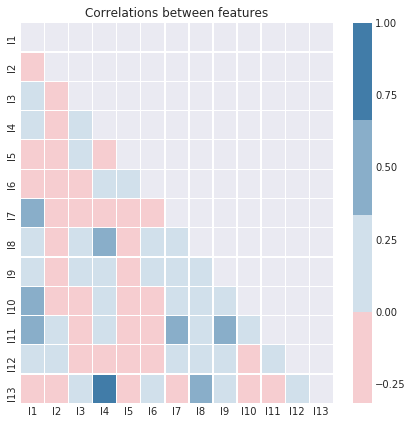

In [264]:
# Correlation between numerical features
corr = toy_df_num.corr()
fig, ax = plt.subplots(figsize=(7, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.2)
plt.title("Correlations between features")
plt.show()

We observe that some of the numerical variables are highly correlated with each other. In the context of Logistic Regression we would want to eliminate features that are highly correlated with each other. A regularization  technique like Lasso or Ridge could take care of this. However, since Logistic regression is just our baseline model and we are focusing on tree-based algorithms, we do not need to worry about this. Tree-based models know how to assign variable importance and do not require any significant feature engineering. 

### 2.8 Categorical Features

In this section, we will perform data processing on the 26 categorical features of the dataset. We will start by performing some EDA to compute the **number of unique categories** within each categorical feature and the total counts for each category. 

In [77]:
def count_categories(dataRDD, var, var_position, top):
    """
    input: RDD, name and position of a categorical variable 
    
    output: 
    * number of unique categories in the variable
    * counts of each category occurance by label
    """
    
    # counting category occurance within each categorical feature 
    count_per_category = dataRDD.map(lambda x: ( x[0][var_position], 1)) \
                                           .reduceByKey(lambda x,y: x+y) \
                                           .sortBy(lambda x: -x[1])

    # counting number of unique values within the categorical variable
    num_unique_values = count_per_category.map(lambda x: x[0]).distinct().count()

    print('Unique values within the category:', num_unique_values)
    print(' ')
    top_x = count_per_category.take(top)
    print('Top {} categories by count:'.format(top))
    for i in top_x: 
        print('Category: {}; Count: {}'.format(i[0],i[1]))
    print(' ')

In [197]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position > 12 and var_position < 39:
        print(" ")
        print("VARIABLE {}".format(var))
        print(" ")
        count_categories(normedToyRDDCached, var, var_position=var_position, top=10)

 
VARIABLE C1
 
Unique values within the category: 57
 
Top 10 categories by count:
Category: 05db9164; Count: 485
Category: 68fd1e64; Count: 146
Category: 5a9ed9b0; Count: 103
Category: 8cf07265; Count: 51
Category: be589b51; Count: 41
Category: 5bfa8ab5; Count: 27
Category: f473b8dc; Count: 20
Category: 87552397; Count: 15
Category: 39af2607; Count: 13
Category: 9a89b36c; Count: 9
 
 
VARIABLE C2
 
Unique values within the category: 193
 
Top 10 categories by count:
Category: 38a947a1; Count: 114
Category: 1cfdf714; Count: 50
Category: 287130e0; Count: 46
Category: 38d50e09; Count: 46
Category: 207b2d81; Count: 37
Category: 09e68b86; Count: 33
Category: 421b43cd; Count: 33
Category: 4f25e98b; Count: 29
Category: 89ddfee8; Count: 27
Category: 58e67aaf; Count: 27
 
 
VARIABLE C3
 
Unique values within the category: 771
 
Top 10 categories by count:
Category: null; Count: 34
Category: d032c263; Count: 15
Category: 02cf9876; Count: 13
Category: b00d1501; Count: 12
Category: 77f2f2e5; Cou

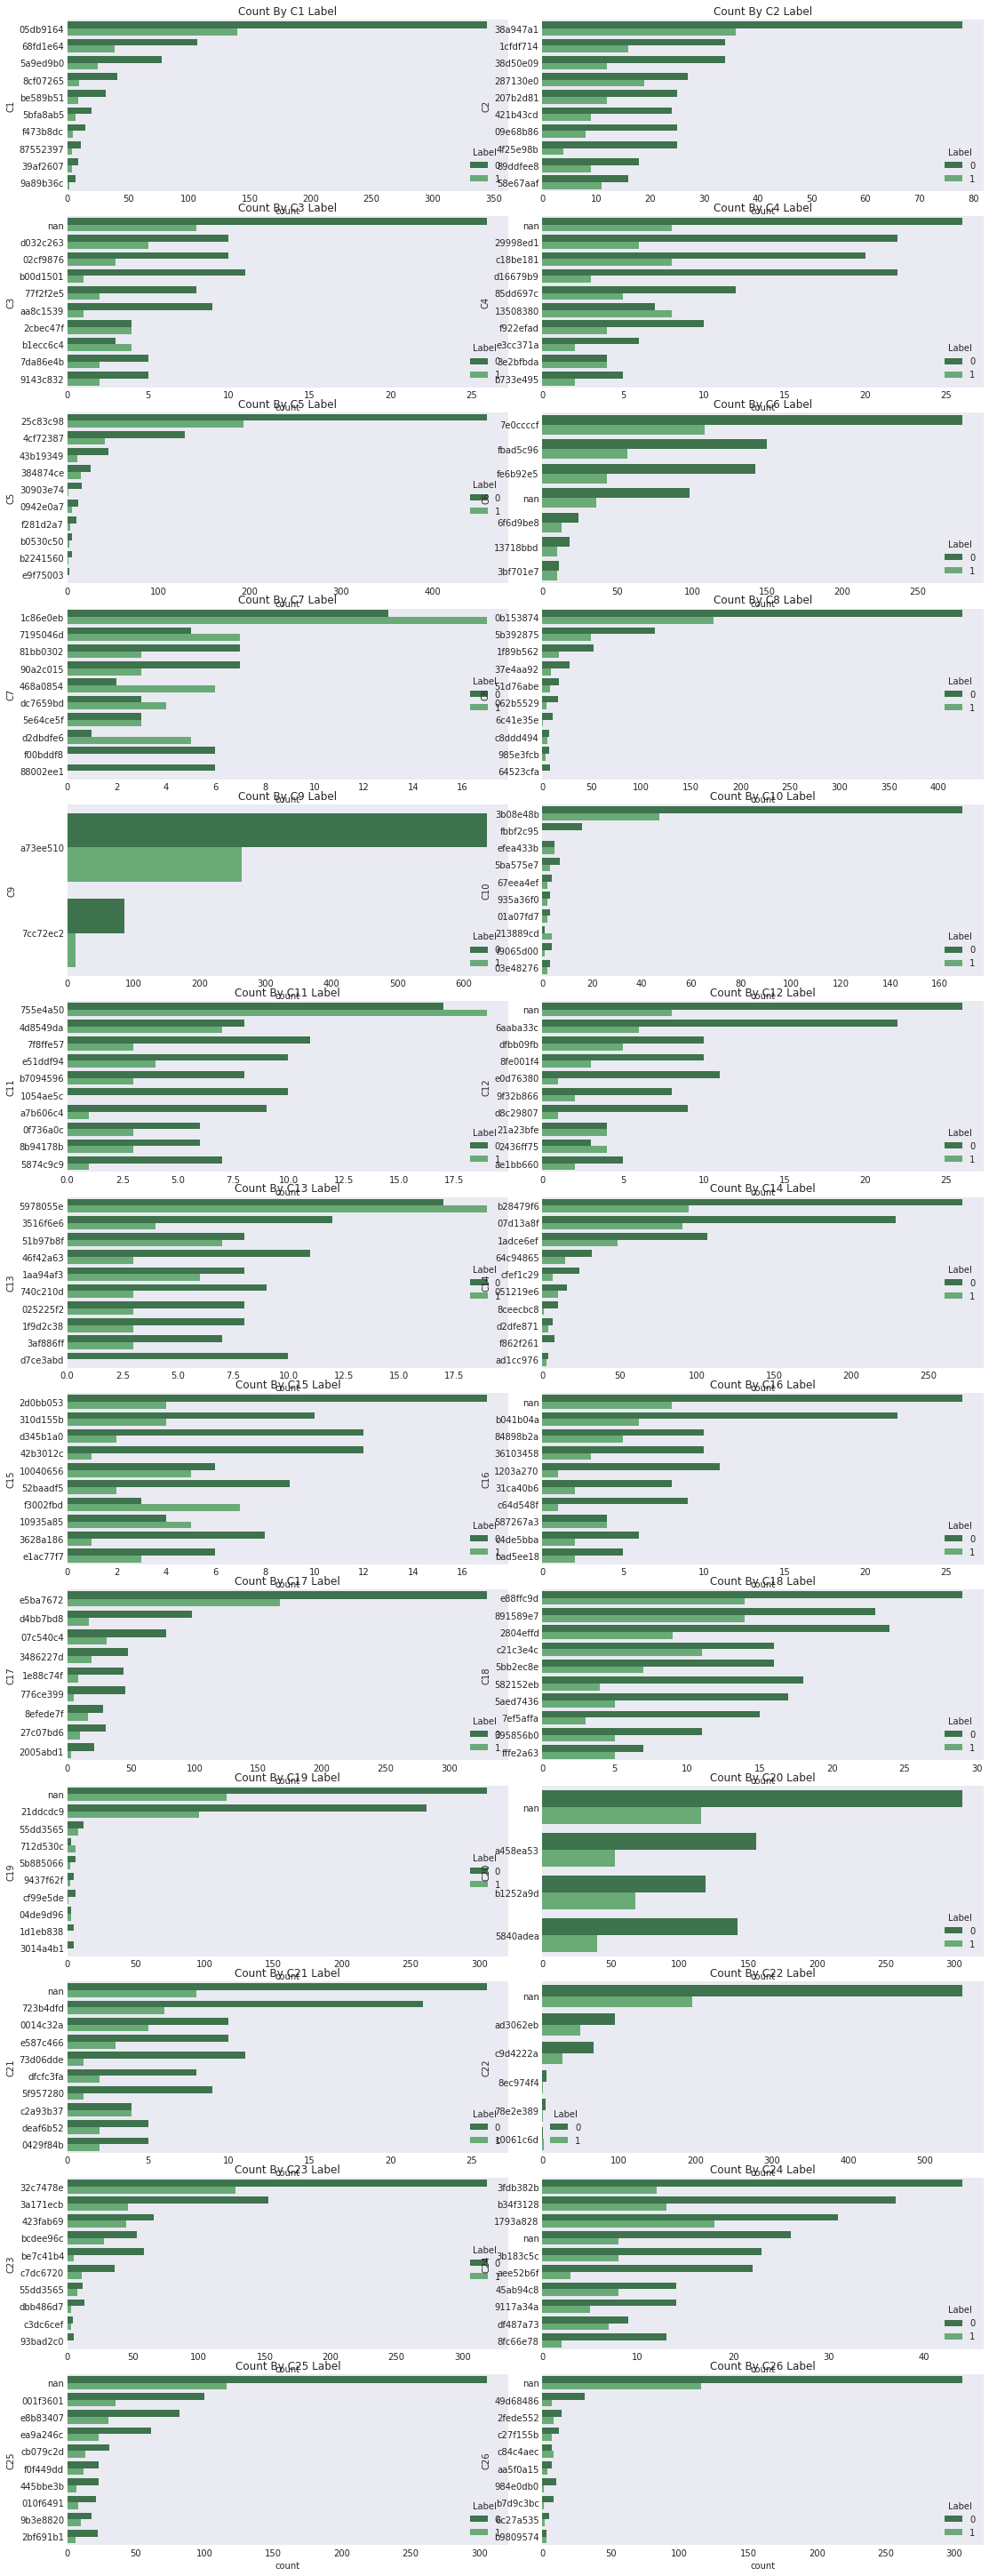

In [275]:
# Bar graphs of category counts within each categorical variable by label
fig, ax = plt.subplots(13, 2,figsize=(15,40))
plt.tight_layout()
fno = 0
# axes are in a two-dimensional array, indexed by [row, col]
for i in range(13):
    for j in range(2):
        fno += 1
        col = "C" + str(fno)
        sns.countplot(y=col, hue="Label", data=toy_df, palette="Greens_d",
                  order=toy_df[col].value_counts().iloc[:10].index,ax=ax[i,j]).set_title('Count By C'+str(fno)+' Label')

The above analysis shows that some categorical variables have a high number of unique categories. Aditionally, the distribution of counts for most of the categorical variables is very skewed (i.e. some categories appear much more often than others). Considering this information, we decided to take the following approach to deal with categorical variables: 

* Bucket the categories within each categorical feature in 4 groups based on their occurence counts
    * **High frequency**: categories that occur more times than 10% of the total row count (Example: if the total row count is 1000 -> categories that occur *more than 100 times*)
    * **Medium frequency**: categories that occur more times than 2% and less than 10% of the total row count (Example: if the total row count is 1000 -> categories that occur *50-100 times*)
    * **Low frequency**: categories that occur less times than 2% of the total row count (Example: if the total row count is 1000 -> categories that occur *less than 50 times*)
    * **Missing**: null occurencies (note: since there are a couple of categorical variables with significant percentages of null occurencies, we wanted to retain this information to see if it potentially creates some signal for our models)

* Convert the categorical features to numerical using *One-hot Encoding* and the buckets obtained above. Specifically, we decided to keep all the one-hot encoded categories from the High Frequency bucket as separate columns, in order to obtain all signals from the categories that appear to be the most important for our classification problem. However, we decided to not discard the remaining categories/features, but instead add three additional columns one for each of the: Medium frequency, Low frequency and Missing buckets. If, for example, record X has any category that belongs to the Medium frequency bucket (based on the counts explained above), then the `Medium Frequency` column for that record will be `1`, otherwise it will be `0`. 

Below, we will demonstrate how the bucketing and one-hot encoding were applied in a scalable manner to our Criteo dataset, using our toy dataset with 1000 rows.

**Step 1**. Obtain the occurence counts for each category:

> *part a:* Using variable `C1` as an example to demonstrate the implementation. The analysis above showed that variable `C1` has 57 uniques categories, hence we will obtain the occurence counts for each of the 57 categories in `C1`. Each of these categories will then be placed in one of the 4 buckets mentioned above based on its occurence counts.

In [265]:
# C1 has var_position = 13
category_counts_C1 = normedToyRDDCached.map(lambda x: ( x[0][13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])

category_counts_C1.take(10)

[('05db9164', 485),
 ('68fd1e64', 146),
 ('5a9ed9b0', 103),
 ('8cf07265', 51),
 ('be589b51', 41),
 ('5bfa8ab5', 27),
 ('f473b8dc', 20),
 ('87552397', 15),
 ('39af2607', 13),
 ('9a89b36c', 9)]

> *part b:* Apply the same logic on all variables using Spark's `flatMap`

In [266]:
# helper function 
def count_cat_count(line):
    features, label = line[0], line[1]
    result = []
    for i in list(range(13,39)): 
        result.append((features[i], 1))
    return result

In [267]:
category_counts_all = normedToyRDDCached.flatMap(count_cat_count) \
                                        .reduceByKey(lambda x,y: x+y) \
                                        .sortBy(lambda x: -x[1]) \
                                        .filter(lambda x: x[0] != 'null') 
category_counts_all.take(10)

[('a73ee510', 900),
 ('25c83c98', 653),
 ('0b153874', 597),
 ('e5ba7672', 497),
 ('05db9164', 485),
 ('32c7478e', 447),
 ('7e0ccccf', 388),
 ('b28479f6', 367),
 ('21ddcdc9', 358),
 ('07d13a8f', 320)]

**Step 2**. Classify each category into one of the 4 buckets mentioned above based on its occurence counts and broadcast this information. As we learned throughout the semester, broadcasted variables are very useful in cases where the programmer wants to pass a copy of some useful information to every node in an efficient manner. 

* `>=` 100 times (i.e. 10% of 1000 rows) -> *High frequency* 
* 20-100 times (i.e. 2-10% of 1000 rows) -> *Medium frequency* 
* `<`20 times (i.e. 2% of 1000 rows) -> *Low frequency* 
* `==` 'null' -> *Missing*


In [268]:
# applying on C1 only 
high_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] >= 100) \
                                               .map(lambda x: x[0]).collect())
medium_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] < 100 and x[1] >= 20) \
                                               .map(lambda x: x[0]).collect())
low_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] < 20) \
                                               .map(lambda x: x[0]).collect())

# applying to all variables  
high_frequency_categorices = sc.broadcast(category_counts_all.filter(lambda x: x[1] >= 100) \
                                               .map(lambda x: x[0]).collect())
medium_frequency_categorices = sc.broadcast(category_counts_all.filter(lambda x: x[1] < 100 and x[1] >= 20) \
                                               .map(lambda x: x[0]).collect())
low_frequency_categorices = sc.broadcast(category_counts_all.filter(lambda x: x[1] < 20) \
                                               .map(lambda x: x[0]).collect())

In [269]:
# C1 
print('High frequency categories: {} \n'.format(high_frequency_categorices_C1.value))
print('Medium frequency categories: {} \n'.format(medium_frequency_categorices_C1.value))
print('Low frequency categories: {} \n'.format(low_frequency_categorices_C1.value))

High frequency categories: ['05db9164', '68fd1e64', '5a9ed9b0'] 

Medium frequency categories: ['8cf07265', 'be589b51', '5bfa8ab5', 'f473b8dc'] 

Low frequency categories: ['87552397', '39af2607', '9a89b36c', 'ae82ea21', '241546e0', '09ca0b81', '17f69355', '439a44a4', '1464facd', 'fb174e6b', 'b455c6d7', '75ac2fe6', '45cb84c9', '28e55712', '7e5c2ff4', 'd4b08d58', 'da4eff0f', 'c974c00b', '42a16b9a', '3b65d647', 'fbc55dae', 'b19f768d', '2ebc17d3', '37d3940e', '5ebc3192', '3c9d8785', '9684fd4d', 'a14cf13a', '49807078', 'dac91c28', '439f942d', '41edac3d', '813d7135', '06584483', '291b7ba2', '40e1377d', 'e8ef605b', '394fc830', 'eb6dcae0', 'bfb430af', '5d7d2fe8', 'c79f9af8', '88abfaf6', '426610d2', '18988050', '0a16e1d4', '92fb1d87', 'c71ae391', 'abca0bad', '46300ee3'] 



In [270]:
# All variables 
print('High frequency categories: {} \n'.format(high_frequency_categorices.value))
print('Medium frequency categories: {} \n'.format(medium_frequency_categorices.value))
# print('Low frequency categories: {} \n'.format(low_frequency_categorices.value)) # this category is too large to print 

High frequency categories: ['a73ee510', '25c83c98', '0b153874', 'e5ba7672', '05db9164', '32c7478e', '7e0ccccf', 'b28479f6', '21ddcdc9', '07d13a8f', '3b08e48b', 'a458ea53', 'fbad5c96', '3a171ecb', 'b1252a9d', 'fe6b92e5', '5840adea', '4cf72387', '5b392875', '1adce6ef', '68fd1e64', 'ad3062eb', '001f3601', 'd4bb7bd8', '38a947a1', 'e8b83407', '423fab69', '07c540c4', '5a9ed9b0', '7cc72ec2'] 

Medium frequency categories: ['c9d4222a', 'ea9a246c', 'bcdee96c', '1f89b562', '3486227d', 'be7c41b4', '43b19349', '3fdb382b', '1e88c74f', '776ce399', '8cf07265', '1cfdf714', 'b34f3128', 'c7dc6720', '1793a828', '64c94865', '287130e0', '38d50e09', 'cb079c2d', '8efede7f', 'e88ffc9d', '384874ce', 'be589b51', '55dd3565', '27c07bd6', '49d68486', '6f6d9be8', '207b2d81', '37e4aa92', '891589e7', '755e4a50', '5978055e', 'f0f449dd', '09e68b86', '421b43cd', '2804effd', '3b183c5c', 'cfef1c29', '445bbe3b', '1c86e0eb', '4f25e98b', '010f6491', '2bf691b1', '29998ed1', '6aaba33c', 'b041b04a', '723b4dfd', '13718bbd', 'c18

**Step 3.** Applying a homegrown one-hot encoding implementation as explained above. 

In [ ]:
# C1 example: the new columns of our dataset now are
FIELDS_NEW = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',          # numerical 
          '05db9164','68fd1e64','5a9ed9b0','Medium_Freq_C1','Low_Freq_C1','Missing_C1',      # categorical 
          'Label']                                                                  


FIELDS_NEW = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',                                    # numerical 
          'high freq feature 1','high freq feature 2'...'high freq feature n','Medium_Freq_C1','Low_Freq_C1','Missing_C1',...,
          'Medium_Freq_C26','Low_Freq_C26','Missing_C26',                                                         # categorical 
          'Label']                         

In [272]:
def OHE_transform(line):
    """
    One hot encoding transformation of an RDD 
    using the high/medium/low/missing logic
    
    returns: (ohe_transformed_features, label)
    """
    features, label = line[0], line[1]
    cat_features = []
    num_features = []
    for i, value in enumerate(features):
        if i > 12 and i < 39: 
            cat_features.append(value)
        else:
            num_features.append(value)

    high_freq_list = [1 if i in cat_features else 0 for i in high_frequency_categorices.value]
    medium_freq = 1 if any(i in cat_features for i in medium_frequency_categorices.value) else 0
    low_freq = 1 if any(i in cat_features for i in low_frequency_categorices.value) else 0
    missing = 1 if any(i in cat_features for i in ['null']) else 0
    ohe_features = high_freq_list + [medium_freq] + [low_freq] + [missing]

    return (num_features + ohe_features, label)

In [273]:
oheTrasformedToyRDDCached = normedToyRDDCached.map(OHE_transform).cache()

In [199]:
print(oheTrasformedToyRDDCached.take(1))

[([-0.5433608510385987, 0.8580968676474047, -0.12839483402657934, 0.0, -0.21404880541365456, 0.3873814615646774, -0.07403520683960009, 0.002878252461803471, 1.0729765767787602, -0.9112734540131763, 0.8646834019878579, 0.0, 0.0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], 1)]


### ...Train/Test Toy Set

For the next section, we will randomly sample a toy held-out dataset, to which we will apply the data transformations that we did above for the toy train set, using the parameters from the train set (i.e. median for imputation, mean and st. deviation for standardization).

`!gshuf -n 300 data/train.txt >> data/toy_test300.txt`

In [282]:
toyTrainRDD = oheTrasformedToyRDDCached

In [287]:
# transforming the test data using the train data parameters 
toy_testRDD = sc.textFile('data/toy_test300.txt')
toyTestRDDCached = toy_testRDD.map(parse).map(edit_data_types).cache()
imputedToyTestRDDCached = toyTestRDDCached.map(lambda x: impute_nulls(x, median_dict_toy)).cache()
normedToyTestRDDCached = imputedToyTestRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()
oheTrasformedToyTestRDDCached = normedToyTestRDDCached.map(OHE_transform).cache()
toyTestRDD = oheTrasformedToyTestRDDCached

In [288]:
print(toyTestRDD.take(1))

[([-0.3718050070197415, -0.19538845905765978, -0.23945961131710256, -0.04609035610338022, -0.2527571739413964, -0.34605167169543277, -0.18066982273331073, -0.43992981858484737, -0.48851359420304374, 0.5068178388073282, -0.3643795000258798, -0.18844495754595464, -0.09211169117156807, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0], 0)]


In [292]:
# transforming both train and test datasets to fit into the algorithm below 
# toyTrainTransRDD = toyTrainRDD.map(lambda x: (np.array(x[0]), x[1]))
# toyTestTransRDD = toyTestRDD.map(lambda x: (np.array(x[0]), x[1]))

## 3. Algorithm Explanation

Given scalability concerns and the need for feature selection, we decided to explore two independent models to assess the optimal performance. We also wanted to identify algorithms that have a history of success in the Spark framework and with binary classification. Logistic Regression and Decision Trees met all of these criteria. Logistic Regession is highly scalable and combined with regularization could aid in feature selection. Decision trees have similar benefits but also require little pre-processing and no direct feature selection. We continued down these parallel paths to compare the performance of these models.

### 3.1 Homegrown implementation of Logistic Regression

In [276]:
# Define the baseline model
BASELINE_1 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#BASELINE_2 = np.array([meanClickthroughs, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [277]:
# Compute log loss for Logisitc Regression
def LRLoss(cachedRDD, W):
    augmentedData = cachedRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda x: -x[1] * np.log(1/ (1 + np.exp(-(np.dot(x[0],W))))) - (1-x[1]) * np.log(1-(1/ (1 + np.exp(-(np.dot(x[0],W))))))).mean()
    return loss

In [278]:
#Using meanClickthroughs as our bias term improves loss significantly (it will be used in our baseline)

train_loss_baseline1 = LRLoss(normedRDD_train, BASELINE_1)
print("Train Loss using 0 for baseline", train_loss_baseline1)

train_loss_baseline2 = LRLoss(normedRDD_train, BASELINE_2)
print("Train Loss using meanClickthroughs as baseline", train_loss_baseline2)


NameError: name 'normedRDD_train' is not defined

In [279]:
# BASELINE = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# np.zeros(47)
BASELINE = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [280]:
# Compute the gradient for logistic regression (one step)
def GDUpdate(dataRDD, W, learningRate):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean()
    new_model = W - (learningRate * grad)
    return new_model

In [281]:
# Perform one Gradient Descent update with lasso regularization
def GDUpdate_Lasso(dataRDD, W, learningRate, regParam):

    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    #new_model = None    
    wReg = np.sign(W)
    wReg[0] = 0  #set bias to zero
       
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean() + (wReg * regParam)
    new_model = W - (learningRate * grad)
    
    return new_model

In [304]:
new_model = GDUpdate_Lasso(toyTrainRDD, BASELINE, .1, .1)
print(new_model)

[-0.0223      0.00778516  0.00160617  0.00233232  0.00169631 -0.00414153
 -0.00254091  0.0022588   0.00035279  0.00187996 -0.00130449  0.00930351
  0.00417078 -0.00105622 -0.0186     -0.01335    -0.01255    -0.00815
 -0.01025    -0.00955    -0.0086     -0.00885    -0.0083     -0.0069
 -0.0061     -0.00515    -0.00465    -0.00535    -0.00255    -0.00495
 -0.0051     -0.0044     -0.00325    -0.0029     -0.0034     -0.00225
 -0.00325    -0.00405    -0.0021     -0.0026     -0.00105    -0.00235
 -0.00265    -0.0037     -0.0211     -0.0223     -0.01995   ]


In [305]:
def predict_and_score(dataRDD, W, threshold):
    """Assess peformance of current models"""
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
        
    sc.broadcast(W)
    sc.broadcast(threshold)

    def predict_label(line):
        features = line[0]
        label = line[1]
        pred = None
        z = np.dot(features,W)
        prob = np.divide(1.0, (1.0 + np.exp(-z)))
        if prob > threshold:
            pred = float(1.0)
        else:
            pred = float(0.0)
        return label, pred
        
    def map_accuracy(line):
        label_actual = line[0]        
        label_pred = line[1]
        
        if label_actual == 1.0 and label_pred == 1.0:
            return "TP", 1.0
        elif label_actual == 1.0 and label_pred == 0.0:
            return "FN", 1.0
        elif label_actual == 0.0 and label_pred == 0.0:
            return "TN", 1.0
        else:
            if label_actual == 0.0 and label_pred == 1.0:
                return "FP", 1.0
    
    scores = augmentedData.map(predict_label).map(map_accuracy).reduceByKey(lambda x, y: x + y).collect()
    
    TP, FN, TN, FP = 0.0, 0.0, 0.0, 0.0

    for i in scores:
        if i[0] == 'TP':
            TP = i[1]
        elif i[0] == 'FN':
            FN = i[1]
        elif i[0] == 'TN':
            TN = i[1]
        else:
            if i[0] == 'FP':
                FP = i[1]

    if TP != 0.0:
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        f1_score = 2*((precision*recall)/(precision+recall))
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        false_positive_rate = FP/(FP+TN)
        
    else:
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
        accuracy = 0.0
        false_positive_rate = 0.0

#     print("scores=", scores)
#     print("True Positives=", TP)
#     print("False Negatives=", FN)
#     print("True Negatives=", TN)
#     print("False Positives=", FP)
#     print("Precision=", precision)
#     print("Recall=", recall)
#     print("F1_score=", f1_score)
#     print('Accuracy=', accuracy)

    return accuracy, precision, recall, f1_score, false_positive_rate
    

In [307]:
updated_model = GDUpdate_Lasso(toyTrainRDD, BASELINE, .1, .1)

In [308]:
predict_and_score(toyTrainRDD, updated_model, threshold=.55)

(0.0, 0.0, 0.0, 0.0, 0.0)

In [312]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = True):
    """
    Perform nSteps iterations of Logistic Regression gradient descent and 
    track performance metrics on the test and train set. 
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    accuracies, f1_scores, precisions, recalls, false_positive_rates = [], [], [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## CORE CODE #############
        
        new_model = GDUpdate(trainRDD, model, learningRate=0.1)
        training_loss = LRLoss(trainRDD, new_model)
        test_loss = LRLoss(testRDD, new_model)
        accuracy, precision, recall, f1_score, false_positive_rate = predict_and_score(toyTrainRDD, new_model, threshold=.55)
        
        model = new_model
        
        ############## (END) CORE CODE #############
        
        # keep track of metrics for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
        false_positive_rates.append(false_positive_rate)
        
        # console output
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"False Positive Rate: {false_positive_rate}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history, accuracies, f1_scores, precisions, recalls, false_positive_rates

In [314]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
logLossTrain, logLossTest, model_history, accuracy, f1_score, precision, recall, false_positive_rate = GradientDescent(toyTrainRDD, toyTestRDD, wInit, nSteps = 30)
print(f"\n... trained {30} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.6606005638451372
test loss: 0.6581105815492014
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
False Positive Rate: 0.0
Model: [-0.022, 0.008, 0.002, 0.002, 0.002, -0.004, -0.003, 0.002, 0.0, 0.002, -0.001, 0.009, 0.004, -0.001, -0.019, -0.013, -0.013, -0.008, -0.01, -0.01, -0.009, -0.009, -0.008, -0.007, -0.006, -0.005, -0.005, -0.005, -0.003, -0.005, -0.005, -0.004, -0.003, -0.003, -0.003, -0.002, -0.003, -0.004, -0.002, -0.003, -0.001, -0.002, -0.003, -0.004, -0.021, -0.022, -0.02]
----------
STEP: 2
training loss: 0.6379671439857193
test loss: 0.633382659724803
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
False Positive Rate: 0.0
Model: [-0.041, 0.015, 0.003, 0.004, 0.003, -0.008, -0.005, 0.004, 0.001, 0.004, -0.002, 0.018, 0.008, -0.002, -0.034, -0.024, -0.023, -0.014, -0.019, -0.017, -0.016, -0.016, -0.015, -0.013, -0.011, -0.01, -0.009, -0.01, -0.004, -0.009, -0.009, -0.008, -0.006, -0.005, -0.006, -0.004, -0.006, -0.008, -0.004, -0.005, -0.002, -0.004, 

In [315]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss') #trainLoss[1:]
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')

    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Performance')
    if title:
        plt.title(title)
    plt.show()

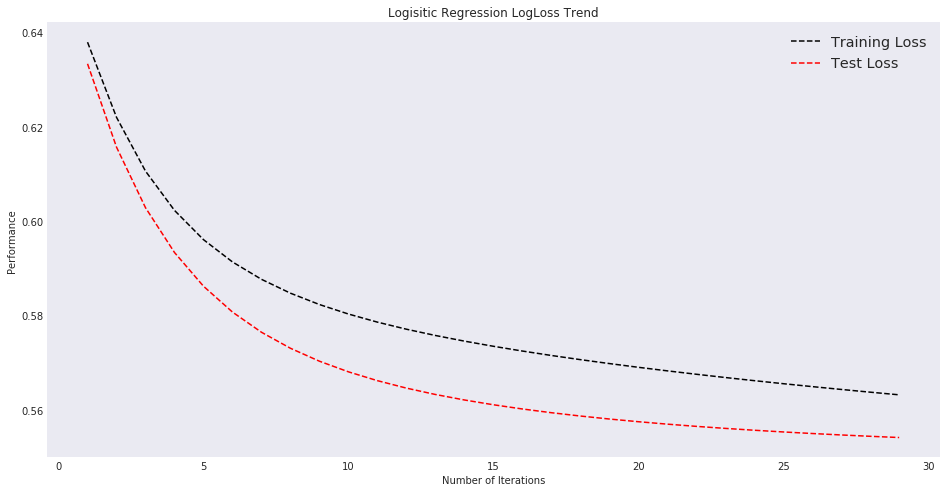

In [316]:
LR_LogLoss_learningRate_point2 = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_LogLoss_learningRate_point2

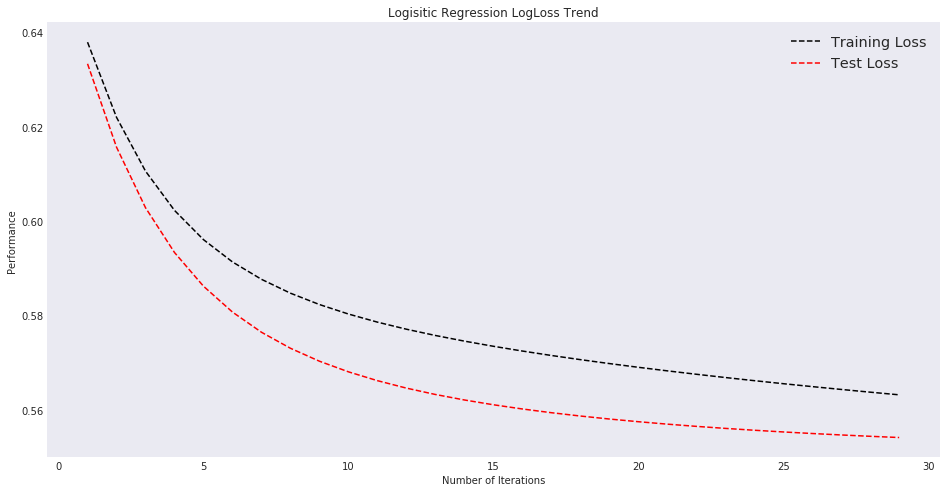

In [317]:
LR_LogLoss_lasso = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_LogLoss_lasso

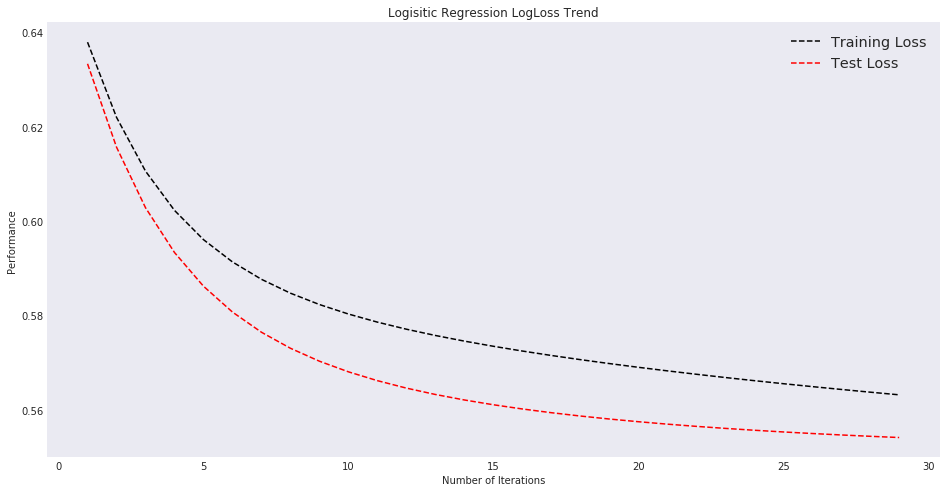

In [318]:
LR_Loss_original = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_Loss_original

In [319]:
def plotPerformance(accuracy, f1_score, title = None):
    """
    Helper function for plotting.    
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(accuracy)))[1:]
    ax.plot(x, accuracy[1:], 'r--', label='Accuracy')
    ax.plot(x, f1_score[1:], 'k--', label='F1_score')
    #ax.plot(x, precision[1:], 'g--', label='Precision')
    #ax.plot(x, recall[1:], 'b--', label='Recall')

    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Performance')
    if title:
        plt.title(title)
    plt.show()
    
    #precision, recall

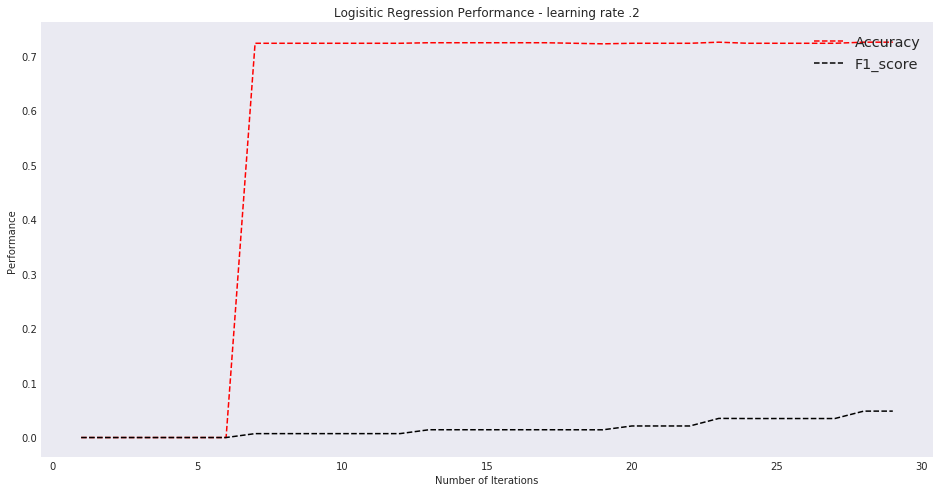

In [320]:
LR_performance_learningRate_point2 = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - learning rate .2')
LR_performance_learningRate_point2

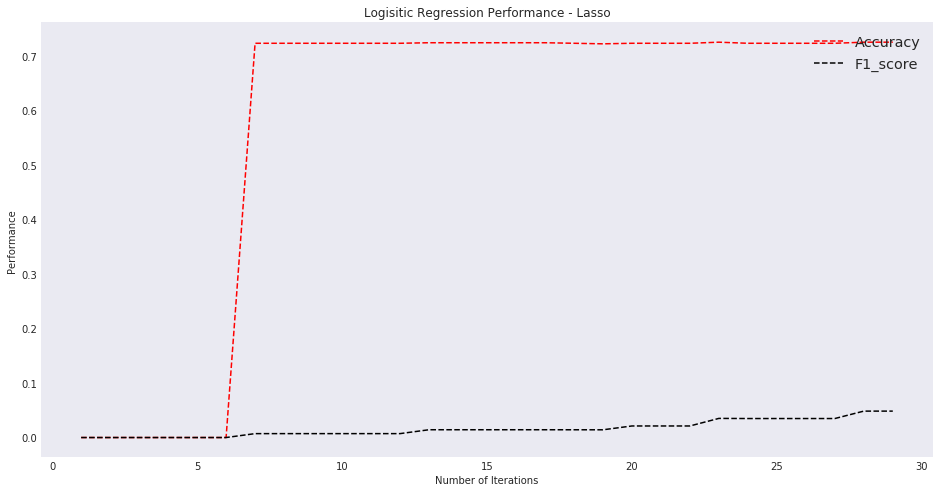

In [321]:
LR_performance_lasso = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - Lasso')
LR_performance_lasso

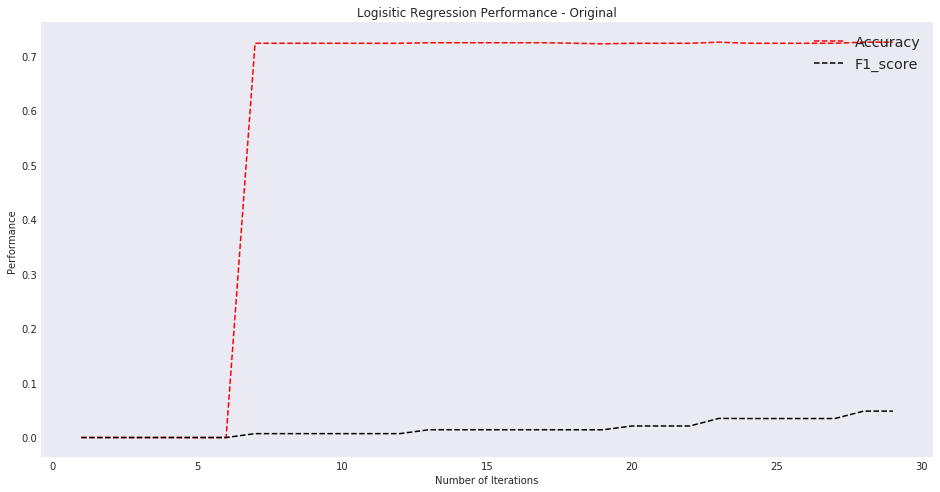

In [322]:
LR_performance_original = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - Original')
LR_performance_original

In [323]:
def plotROCcurves(recall, false_positive_rate, title = None):
    """
    Helper function for plotting.    
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    #x = list(range(len(recall)))[1:]
    #y = list(range(len(false_positive_rate)))[1:]
    
    #ax.plot(false_positive_rate[1:], recall[1:], 'r--', label='False Positive Rate')

    ax.plot(false_positive_rate, recall, 'r--')

    #ax.plot(x, false_positive_rate[1:], 'r--', label='False Positive Rate')
    #ax.plot(y, recall[1:], 'k--', label='True Positive Rate')

    #ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.show()

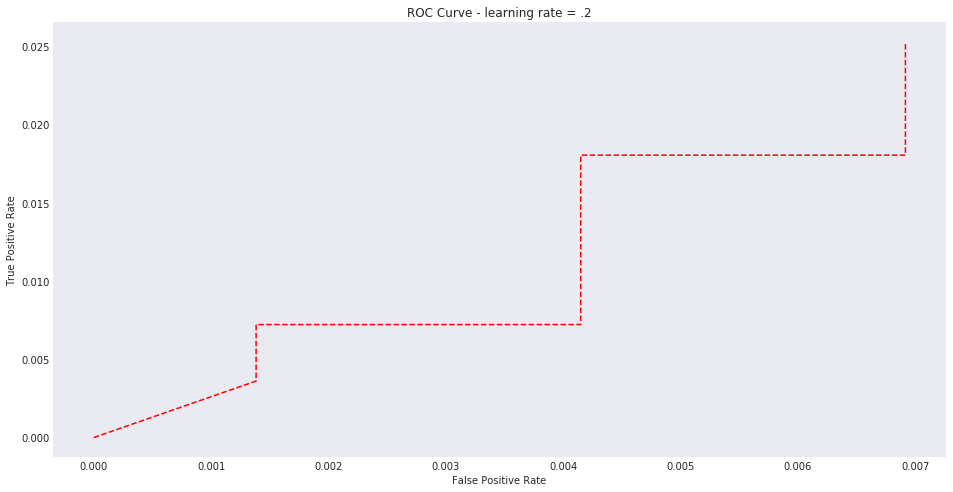

In [324]:
ROC_learning_rate2 = plotROCcurves(recall, false_positive_rate, title = "ROC Curve - learning rate = .2")
ROC_learning_rate2

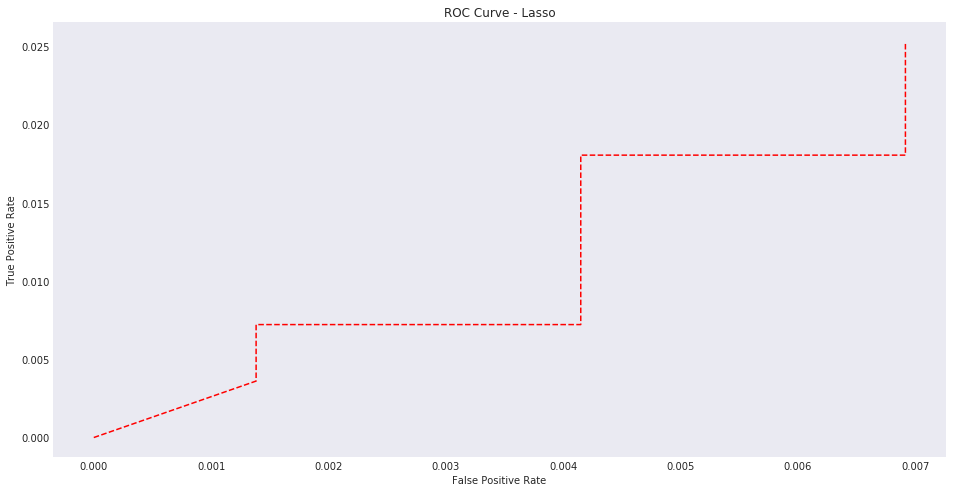

In [325]:
ROC_lasso = plotROCcurves(recall, false_positive_rate, title = "ROC Curve - Lasso")
ROC_lasso 

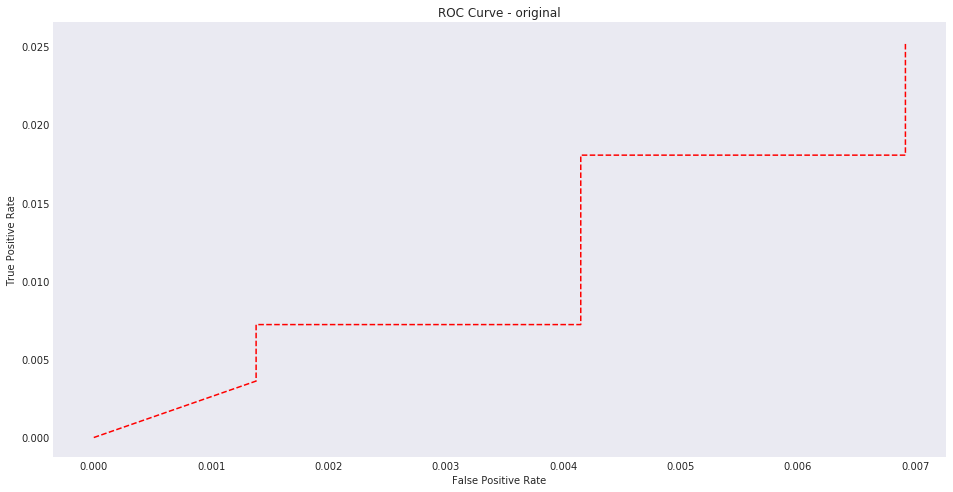

In [326]:
ROC_original = plotROCcurves(recall, false_positive_rate, title = "ROC Curve - original")
ROC_original 

### 3.2 Homegrown implementation of Decision Trees

## 4. Algorithm Implementation

# PLACEHOLDER: 
## EDA with Spark DFs on full data
## LR and Trees with Spark ML on full data 

## 5. Application of Course Concepts